# Notebook: HumanEval Evaluation

This notebook performs the **final evaluation phase** of the GRPO verifiable-reward coding project using the **HumanEval benchmark**.

---

## Objective

Evaluate and compare the functional correctness of multiple models trained under different regimes:

- **Base model** (no fine-tuning)
- **SFT model** (supervised fine-tuning warm-up)
- **GRPO model** (verifiable-reward reinforcement learning)

Each model is evaluated in both:
- **Non-CoT mode** (direct code completion)
- **CoT mode** (reasoning + solution, schema-constrained)

The goal is to measure **pass@1 performance** under a **strict execution harness**, ensuring all outputs are runnable, well-formed Python.

---

## Evaluation Protocol

1. **Prompt Construction**
   - Non-CoT: model completes the function body directly.
   - CoT: model is instructed to emit reasoning followed by a `<SOLUTION>` block.

2. **Batch Generation**
   - All HumanEval tasks are generated using **vLLM batch inference** for speed and determinism.
   - Stop tokens are applied to prevent over-generation.

3. **Output Sanitization**
   A custom `cleaner` function enforces:
   - Strict `<SOLUTION>` extraction (CoT only)
   - Markdown fence removal (```python … ```)
   - Redundant `def` removal
   - Docstring stripping
   - Robust indentation normalization compatible with the HumanEval harness

4. **Execution-Based Scoring**
   - Each completion is executed against the official HumanEval tests.
   - Results are aggregated into a single results table.

---

## Metrics

- **pass@1**: fraction of problems solved correctly on the first attempt
- Results are reported per model and per generation mode (CoT / non-CoT)

Duplicate rows from batched generation are explicitly deduplicated before scoring.

---

## Output Artifacts

- `*_non_cot.jsonl` — raw non-CoT completions
- `*_cot.jsonl` — raw CoT completions
- `df_results` — consolidated evaluation table with pass@1 scores

These artifacts form the **final empirical evidence** for assessing GRPO effectiveness.

---

## Result Summary

- Generation stability issues (empty outputs, truncation) were resolved by:
  - Removing aggressive repetition penalties
  - Correcting stop-token logic
  - Fixing markdown and tag-handling bugs in the cleaner
- Final runs achieved **near-complete coverage** (≤1 empty completion out of 164)
- GRPO shows measurable gains over Base and SFT under controlled conditions

# Step 1: Mounting Google Drive and Importing Libraries


In [30]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/grpo-verified-reasoner
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/grpo-verified-reasoner
data			      LICENSE	 outputs    unsloth_compiled_cache
grpo_trainer_lora_model       models	 README.md  _unsloth_sentencepiece_temp
huggingface_tokenizers_cache  notebooks  src	    wandb


In [ ]:
# Install UV (Faster pip)
!pip install --upgrade -qqq uv

In [32]:
import os
import subprocess

In [33]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:False"

In [34]:
# os.environ["UNSLOTH_VLLM_STANDBY"] = "1"

In [35]:
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install -q unsloth vllm human-eval tqdm
else:
    # Version matching for Colab GPUs
    try:
        import numpy, PIL
        get_numpy = f"numpy=={numpy.__version__}"
        get_pil   = f"pillow=={PIL.__version__}"
    except Exception:
        get_numpy, get_pil = "numpy", "pillow"

    try:
        is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
    except Exception:
        is_t4 = False

    # A100/H100: vllm 0.10.2, T4: vllm 0.9.2 + pinned triton
    get_vllm, get_triton = ("vllm==0.9.2", "triton==3.2.0") if is_t4 else ("vllm==0.10.2", "triton")

    !uv pip install -qqq --upgrade \
        unsloth {get_vllm} {get_numpy} {get_pil} torchvision bitsandbytes xformers tqdm human-eval
    !uv pip install -qqq {get_triton}

In [36]:
import gc
import json
import re
import ast
import torch
import random
import textwrap
import numpy as np
from tqdm import tqdm
import pandas as pd

from unsloth import FastLanguageModel
from vllm import SamplingParams
from pathlib import Path

import matplotlib.pyplot as plt
from human_eval.data import read_problems, write_jsonl
from human_eval.evaluation import evaluate_functional_correctness

In [9]:
SEED = 3407
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-33b9d626-6ba6-d058-aec3-b7e7ebe44803)


# Step 2: Verifying GPU and Environment

In [10]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Torch version: 2.8.0+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


# Step 3: Setting Up the Main Variables

In [37]:
# HumanEval evaluation settings
N_SAMPLES_PER_PROBLEM = 1          # pass@1 by default; raise to 5 or 10 if you later want pass@k
MAX_NEW_TOKENS_NON_COT = 1024       # Non-CoT completions are usually short (function body)
MAX_NEW_TOKENS_COT = 2048           # CoT can be longer due to tags + full function

TEMP_NON_COT = 0.0                # low sampling noise; stable for benchmarking
TEMP_COT = 0.0                     # encourages exploration under schema (optional)

TOP_P = 0.95
MIN_P = 0.10

# Stop guards (prevent rambling without clipping typical solutions)
STOP_STRINGS = ["\nclass ", "\ndef ", "\nif __name__"]

In [38]:
# Output paths (keep all artifacts under one folder)
EVAL_DIR = "data/evaluation"
os.makedirs(EVAL_DIR, exist_ok=True)

In [39]:
# Model paths / identifiers
BASE_MODEL_PATH = "unsloth/Qwen3-4B-Base"
SFT_MODEL_PATH  = "models/qwen3-4b-sft-merged-f32"
GRPO_MODEL_PATH = "models/qwen3-4b-grpo-merged-f32-final"

In [40]:
COT_SYSTEM_PROMPT_HUMANEVAL = """You are a code-generation engine.
You must output your response in the following exact format:
<START_WORKING_OUT>
Concise reasoning steps required to solve the problem.
</END_WORKING_OUT>
<SOLUTION>
Valid Python code only.
</SOLUTION>
Do not output anything outside these tags."""

# Step 4: Loading HumanEval Problems

In [41]:
problems = read_problems()  # dict: {task_id: {"prompt":..., "test":..., "entry_point":...}}
task_ids = list(problems.keys())

print(f"Loaded HumanEval problems: {len(task_ids)}")
print("Example task_id:", task_ids[0])
print("\n--- Prompt Preview ---")
print(problems[task_ids[0]]["prompt"][:500])

Loaded HumanEval problems: 164
Example task_id: HumanEval/0

--- Prompt Preview ---
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """



# Step 5: Prompt Builders

In [42]:
def build_non_cot_prompt(problem: dict) -> str:
    """
    Non-CoT: HumanEval-style continuation.
    We provide ONLY the HumanEval prompt.
    The harness will prepend this prompt again during execution.
    """
    return problem["prompt"]

In [43]:
def build_cot_prompt(problem: dict, tokenizer) -> str:
    """
    CoT: Uses the same chat template distribution as SFT/GRPO training.
    Returns a fully formatted ChatML prompt string.
    """
    messages = [
        {"role": "system", "content": COT_SYSTEM_PROMPT_HUMANEVAL},
        {"role": "user", "content": problem["prompt"]},
    ]
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

# Step 6: Output Post-processing Logic

In [44]:
# Stop strings (for safety against rambling)
# These are conservative: they stop the model from starting a NEW definition / class / main block.
STOP_STRINGS = ["\nclass ", "\ndef ", "\nif __name__"]

SOLUTION_RE = re.compile(r"<SOLUTION>(.*?)</SOLUTION>", re.DOTALL | re.IGNORECASE)

In [45]:
def extract_cot_solution(completion_only_text: str) -> str:
    """
    Extract code from <SOLUTION>...</SOLUTION>.
    Returns "" on failure (schema violation → harness will fail, which is correct behavior).
    """
    m = SOLUTION_RE.search(completion_only_text)
    if not m:
        return ""
    return m.group(1).strip()

In [46]:
def truncate_on_stop_strings(text: str, stop_strings: list[str]) -> str:
    """
    Stops the completion if it begins a new unrelated block (def/class/main).
    This reduces harness crashes from rambling continuations.
    """
    cut = len(text)
    for s in stop_strings:
        idx = text.find(s)
        if idx != -1:
            cut = min(cut, idx)
    return text[:cut].rstrip()

In [65]:
def cleaner(code: str, entry_point: str, use_cot: bool) -> str:
    """
    Cleans model completions for HumanEval.
    Handles GRPO models that redundantly define the entry function.
    Preserves helper functions and relative nesting.
    REMOVED: One-liner split logic to prevent signature parsing errors.
    """
    # A. EXTRACT CoT (Standard): Extract code enclosed within <SOLUTION> tags if CoT is enabled.
    if use_cot:
        if "<SOLUTION>" in code:
            code = code.split("<SOLUTION>")[-1]
            if "</SOLUTION>" in code:
                code = code.split("</SOLUTION>")[0]
        else:
            # If CoT is requested but tags are missing, return empty to indicate failure.
            return ""

    # B. REMOVE MARKDOWN & DOCSTRINGS: Strip markdown fences and docstrings.
    code = code.replace("```python", "").replace("```", "")
    # Remove docstrings early to prevent them from messing up indentation detection.
    code = re.sub(r'(\s*("""|"\"\")[[\s\S]]*?\2)', '', code, count=1)

    lines = code.split('\n')
    filtered_lines = []

    # C. PRE-FILTERING: Remove 'from typing' imports, which are noise in HumanEval.
    for line in lines:
        if line.strip().startswith("from typing"):
            continue
        filtered_lines.append(line)

    lines = filtered_lines

    # D. SURGICAL DEDENT LOGIC: Adjust indentation based on function definition.
    # We look for the line defining the entry point to decide our strategy.
    def_pattern = re.compile(rf"^\s*def\s+{re.escape(entry_point)}(\s*\(|\s*:)")

    header_index = -1
    for i, line in enumerate(lines):
        if def_pattern.match(line):
            header_index = i
            break

    final_lines = []

    if header_index != -1:
        # --- CASE 1: Redundant Header Found (GRPO Style) ---

        # 1. Keep everything BEFORE the header as-is (Helpers).
        pre_header_lines = lines[:header_index]

        # 2. Process everything AFTER the header (The Body).
        # We strictly discard the header line itself.
        # [REMOVED] The logic that looked for code on the same line.
        post_header_lines = lines[header_index+1:]

        # 3. Calculate Body Indentation from the first valid body line.
        body_indent = 0
        for line in post_header_lines:
            if line.strip():
                body_indent = len(line) - len(line.lstrip())
                break

        # 4. Dedent the body lines by that specific amount.
        normalized_body = []
        for line in post_header_lines:
            if not line.strip():
                normalized_body.append("")
                continue
            # Shift left, but don't go negative.
            current = len(line) - len(line.lstrip())
            new_indent = max(0, current - body_indent)
            normalized_body.append(" " * new_indent + line.lstrip())

        final_lines = pre_header_lines + normalized_body

    else:
        # --- CASE 2: No Header Found (SFT Style / Nested) ---
        # Normalize the entire block based on the first line's indentation.
        global_indent = 0
        for line in lines:
            if line.strip() and not line.strip().startswith(("import ", "from ")):
                global_indent = len(line) - len(line.lstrip())
                break

        for line in lines:
            if not line.strip():
                final_lines.append("")
                continue
            current = len(line) - len(line.lstrip())
            new_indent = max(0, current - global_indent)
            final_lines.append(" " * new_indent + line.lstrip())

    # E. FINAL GLOBAL INDENT: Indent everything by 4 spaces for harness compatibility.
    result = "\n".join(final_lines)
    return textwrap.indent(result, '    ')

# Step 7: Unit Tests

In [48]:
# Helper: syntax validator
def assert_valid_python(code: str):
    try:
        ast.parse(code)
    except SyntaxError as e:
        raise AssertionError(f"Invalid Python code:\n{code}\n\nError: {e}")

In [49]:
# Test runner
def run_test(name, raw, entry_point, use_cot=True):
    print(f"\n=== TEST: {name} ===")
    cleaned = cleaner(raw, entry_point=entry_point, use_cot=use_cot)
    print(cleaned)
    assert_valid_python(
        f"def {entry_point}():\n{cleaned}"
    )
    print("Passed")

In [50]:
# 1. Non-CoT baseline (pure continuation)
run_test(
    name="Non-CoT simple continuation",
    raw="""
return x + 1
""",
    entry_point="f",
    use_cot=False
)


=== TEST: Non-CoT simple continuation ===

    return x + 1

Passed


In [51]:
# 2. CoT with redundant entry point
run_test(
    name="CoT redundant entry point",
    raw="""
<SOLUTION>
def f(x):
    return x + 1
</SOLUTION>
""",
    entry_point="f",
    use_cot=True
)


=== TEST: CoT redundant entry point ===

    return x + 1

Passed


In [52]:
# 3. Helper BEFORE entry point (critical bug case)
run_test(
    name="Helper before entry point",
    raw="""
<SOLUTION>
def helper(x):
    return x * 2

def f(n):
    return helper(n)
</SOLUTION>
""",
    entry_point="f",
    use_cot=True
)


=== TEST: Helper before entry point ===

    def helper(x):
        return x * 2

    return helper(n)

Passed


In [53]:
# 4. Helper INSIDE entry point (must remain untouched)
run_test(
    name="Helper inside entry point",
    raw="""
<SOLUTION>
def f(nums):
    def digit_sum(n):
        return sum(map(int, str(abs(n))))
    return sorted(nums, key=digit_sum)
</SOLUTION>
""",
    entry_point="f",
    use_cot=True
)


=== TEST: Helper inside entry point ===

    def digit_sum(n):
        return sum(map(int, str(abs(n))))
    return sorted(nums, key=digit_sum)

Passed


In [55]:
# 5. Mixed helpers + logic (stress test)
run_test(
    name="Mixed helpers and body",
    raw="""
<SOLUTION>
def helper1(x):
    return x + 1

def helper2(x):
    return x * 2

def f(n):
    a = helper1(n)
    b = helper2(a)
    return b
</SOLUTION>
""",
    entry_point="f",
    use_cot=True
)


=== TEST: Mixed helpers and body ===

    def helper1(x):
        return x + 1

    def helper2(x):
        return x * 2

    a = helper1(n)
    b = helper2(a)
    return b

Passed


# Step 8: Defining Evaluation Loop

In [56]:
# This is the new function that accounts for the fp32 models that we just recently merged
# We found out that the reason why the SFT and the GRPO models were giving the same outputs was because the models were being loaded in low-repcision
# Which effectively destroyed the (tiny) updates that we made to the weights via SFT and GRPO
def evaluate_model(
    model_path: str,
    problems: dict,
    task_ids: list[str],
    *,
    use_cot: bool,
    output_jsonl: str,
    max_new_tokens: int,
    temperature: float,
    top_p: float = 0.95,
    min_p: float = 0.10,
    load_in_4bit: bool = False, # Controls 4-bit quantization for model loading
    dtype = torch.float16,      # Specifies the floating point precision (e.g., FP16, BF16)
    gpu_memory_utilization: float = 0.8, # Sets GPU memory allocation for vLLM
):
    # Log current model and mode for clarity
    print(f"\n Loading: {model_path} | Mode: {'CoT' if use_cot else 'Non-CoT'}")
    print(f" Precision: {dtype} | 4-Bit Quantization: {load_in_4bit}")

    # Clear GPU memory before loading a new model
    gc.collect()
    torch.cuda.empty_cache()

    # Load the language model with specified precision and vLLM for inference
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_path,
        max_seq_length=4096,
        load_in_4bit=load_in_4bit, # Use 4-bit quantization if specified
        dtype=dtype,               # Load model with the desired data type
        fast_inference=True,       # Enable vLLM for faster inference
        gpu_memory_utilization=gpu_memory_utilization,
    )
    FastLanguageModel.for_inference(model) # Prepare model for inference mode

    prompts = []
    print(f" Preparing {len(task_ids)} prompts...")
    # Generate prompts for each task based on CoT or Non-CoT mode
    for task_id in task_ids:
        problem = problems[task_id]
        if use_cot:
            prompt_text = build_cot_prompt(problem, tokenizer)
        else:
            prompt_text = build_non_cot_prompt(problem)
        prompts.append(prompt_text)

    # Define stop tokens based on generation mode (CoT or Non-CoT)
    if use_cot:
        stop_tokens = ["</SOLUTION>"]
    else:
        stop_tokens = ["\nclass", "\nif __name__", "\nprint", "\ndef "]

    # Configure sampling parameters for vLLM generation
    sampling_params = SamplingParams(
        temperature=temperature,
        top_p=top_p,
        min_p=min_p,
        max_tokens=max_new_tokens,
        stop=stop_tokens,
    )

    print(f" Running vLLM Batch Generation...")
    # Perform batch generation using the loaded model and sampling parameters
    outputs = model.fast_generate(prompts, sampling_params=sampling_params)

    samples = []
    # Process each generated output
    for i, task_id in enumerate(task_ids):
        problem = problems[task_id]
        completion_only = outputs[i].outputs[0].text # Extract raw completion text

        # Clean and format the completion using the 'cleaner' function
        completion = cleaner(completion_only, problem["entry_point"], use_cot)

        # Store task_id, original prompt, and cleaned completion
        samples.append({
            "task_id": task_id,
            "prompt": problem["prompt"],
            "completion": completion
        })

    # Write all processed samples to a JSONL file
    write_jsonl(output_jsonl, samples)
    print(f" Saved {len(samples)} samples to: {output_jsonl}")

    # Clean up model and tokenizer from GPU memory
    del model, tokenizer
    gc.collect()
    torch.cuda.empty_cache()

# Step 9: Generating JSONL Files for Evaluation

In [57]:
GEN_DIR = Path(EVAL_DIR) / "generations_run_2"
GEN_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# BASE MODEL (Non-CoT)
evaluate_model(
    model_path=BASE_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=False,
    output_jsonl=str(GEN_DIR / "base_non_cot.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_NON_COT,
    temperature=TEMP_NON_COT,
)


 Loading: unsloth/Qwen3-4B-Base | Mode: Non-CoT
INFO 01-05 05:21:59 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-05 05:21:59 [vllm_utils.py:732] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.1: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen3-4b-base-unsloth-bnb-4bit with actual GPU utilization = 69.6%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 52.34 GB. 

`torch_dtype` is deprecated! Use `dtype` instead!


INFO 01-05 05:22:22 [__init__.py:1815] Using max model len 4096
WARNING 01-05 05:22:22 [_ipex_ops.py:16] Import error msg: No module named 'intel_extension_for_pytorch'
INFO 01-05 05:22:24 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-05 05:22:24 [lora.py:92] `lora_extra_vocab_size` is deprecated and will be removed in v0.12.0. Additional vocabulary support for LoRA adapters is being phased out.
Unsloth: vLLM Bitsandbytes config using kwargs = {'load_in_8bit': False, 'load_in_4bit': True, 'bnb_4bit_compute_dtype': 'bfloat16', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': True, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': ['lm_head', 'multi_modal_projector', 'merger', 'modality_projection', 'model.layers.0.mlp', 'model.layers.4.mlp', 'model.layers.3.self_attn', 'model.layers.0.self_attn', 'model.layers.6.mlp', 'model.layers.1.self_attn', 

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 01-05 05:22:30 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 01-05 05:22:31 [gpu_model_runner.py:2392] Model loading took 3.3825 GiB and 2.671494 seconds
INFO 01-05 05:22:47 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/ca83b4ba7b/rank_0_0/backbone for vLLM's torch.compile
INFO 01-05 05:22:47 [backends.py:550] Dynamo bytecode transform time: 14.62 s
INFO 01-05 05:22:53 [backends.py:161] Directly load the compiled graph(s) for dynamic shape from the cache, took 4.557 s
INFO 01-05 05:22:57 [monitor.py:34] torch.compile takes 14.62 s in total
INFO 01-05 05:22:59 [gpu_worker.py:298] Available KV cache memory: 50.98 GiB
INFO 01-05 05:22:59 [kv_cache_utils.py:864] GPU KV cache size: 371,248 tokens
INFO 01-05 05:22:59 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 90.64x
INFO 01-05 05:22:59 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 35/35 [00:11<00:00,  3.12it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 19/19 [00:06<00:00,  3.04it/s]

INFO 01-05 05:23:17 [gpu_model_runner.py:3118] Graph capturing finished in 17 secs, took 1.21 GiB
INFO 01-05 05:23:17 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 17 secs.


INFO 01-05 05:23:19 [gpu_worker.py:391] Free memory on device (78.79/79.32 GiB) on startup. Desired GPU memory utilization is (0.6960016128672332, 55.21 GiB). Actual usage is 3.38 GiB for weight, 0.82 GiB for peak activation, 0.02 GiB for non-torch memory, and 1.21 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=53281379123` to fit into requested memory, or `--kv-cache-memory=78605918208` to fully utilize gpu memory. Current kv cache memory in use is 54743094067 bytes.
INFO 01-05 05:23:19 [core.py:218] init engine (profile, create kv cache, warmup model) took 47.65 seconds
INFO 01-05 05:23:20 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-05 05:23:20 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['norm', 'norm1', 'norm2', 'post_attention_layernorm', 'attention_norm', 'ffn_norm', 'layer_norm2', 'q_norm', 'post_layernorm', 'layer_norm1', 'post_feedforward_layernorm', 'input_layernorm'

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at unsloth/qwen3-4b-base-unsloth-bnb-4bit and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['norm', 'norm1', 'norm2', 'post_attention_layernorm', 'attention_norm', 'ffn_norm', 'layer_norm2', 'cross_attn_post_attention_layernorm', 'q_norm', 'post_layernorm', 'layer_norm1', 'post_feedforward_layernorm', 'cross_attn_input_layernorm', 'input_layernorm', 'pre_feedforward_layernorm', 'k_norm']
 Preparing 164 prompts...
 Running vLLM Batch Generation...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/164 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Saved 164 samples to: data/evaluation/generations_run_2/base_non_cot.jsonl


In [28]:
# SFT MODEL (Non-CoT) - - FP32 EVALUATION
evaluate_model(
    model_path=SFT_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=False,
    output_jsonl=str(GEN_DIR / "sft_non_cot.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_NON_COT,
    temperature=TEMP_NON_COT,
    load_in_4bit=False,    # Do not compress
    dtype=torch.float16,   # Do not round off
)


 Loading: models/qwen3-4b-sft-merged-f32 | Mode: Non-CoT
 Precision: torch.float16 | 4-Bit Quantization: False
INFO 01-11 08:15:57 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-11 08:15:57 [vllm_utils.py:731] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading models/qwen3-4b-sft-merged-f32 with actual GPU utilization = 15.89%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequences 

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 01-11 08:16:16 [default_loader.py:268] Loading weights took 9.34 seconds
INFO 01-11 08:16:17 [gpu_model_runner.py:2392] Model loading took 7.7976 GiB and 9.516278 seconds
INFO 01-11 08:16:30 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/343b7bb7ec/rank_0_0/backbone for vLLM's torch.compile
INFO 01-11 08:16:30 [backends.py:550] Dynamo bytecode transform time: 12.35 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 504.92it/s, triton_poi_fused_view_6]

INFO 01-11 08:16:32 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 512.04it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 01-11 08:16:40 [backends.py:215] Compiling a graph for dynamic shape takes 8.81 s


INFO 01-11 08:16:43 [monitor.py:34] torch.compile takes 21.16 s in total
INFO 01-11 08:16:45 [gpu_worker.py:298] Available KV cache memory: 4.44 GiB
INFO 01-11 08:16:46 [kv_cache_utils.py:864] GPU KV cache size: 32,320 tokens
INFO 01-11 08:16:46 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 7.89x
INFO 01-11 08:16:46 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.
INFO 01-11 08:16:46 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 11/11 [00:01<00:00,  5.63it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 7/7 [00:01<00:00,  5.47it/s]

INFO 01-11 08:16:49 [gpu_model_runner.py:3118] Graph capturing finished in 3 secs, took 0.05 GiB
INFO 01-11 08:16:49 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 3 secs.
INFO 01-11 08:16:49 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 3 secs.


INFO 01-11 08:16:51 [gpu_worker.py:391] Free memory on device (15.75/79.32 GiB) on startup. Desired GPU memory utilization is (0.15889204639455687, 12.6 GiB). Actual usage is 7.8 GiB for weight, 0.36 GiB for peak activation, 0.0 GiB for non-torch memory, and 0.05 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=4555665919` to fit into requested memory, or `--kv-cache-memory=7938765312` to fully utilize gpu memory. Current kv cache memory in use is 4767478271 bytes.
INFO 01-11 08:16:51 [core.py:218] init engine (profile, create kv cache, warmup model) took 34.05 seconds
INFO 01-11 08:16:52 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-11 08:16:52 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['layer_norm1', 'post_attention_layernorm', 'k_norm', 'layer_norm2', 'q_norm', 'post_layernorm', 'ffn_norm', 'norm2', 'norm1', 'pre_feedforward_layernorm', 'attention_norm', 'norm', 'input_layern

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at models/qwen3-4b-sft-merged-f32 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['layer_norm1', 'post_attention_layernorm', 'k_norm', 'layer_norm2', 'cross_attn_post_attention_layernorm', 'q_norm', 'post_layernorm', 'ffn_norm', 'cross_attn_input_layernorm', 'norm2', 'norm1', 'pre_feedforward_layernorm', 'attention_norm', 'norm', 'input_layernorm', 'post_feedforward_layernorm']
 Preparing 164 prompts...
 Running vLLM Batch Generation...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/164 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Saved 164 samples to: data/evaluation/generations_run_2/sft_non_cot.jsonl


In [27]:
# SFT MODEL (CoT) - FP32 EVALUATION
evaluate_model(
    model_path=SFT_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=True,
    output_jsonl=str(GEN_DIR / "sft_cot.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_COT,
    temperature=TEMP_COT,
    load_in_4bit=False,    # Do not compress
    dtype=torch.float16,   # Do not round off
)


 Loading: models/qwen3-4b-sft-merged-f32 | Mode: CoT
 Precision: torch.float16 | 4-Bit Quantization: False
INFO 01-11 08:08:02 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-11 08:08:02 [vllm_utils.py:731] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading models/qwen3-4b-sft-merged-f32 with actual GPU utilization = 79.54%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequences = 12

`torch_dtype` is deprecated! Use `dtype` instead!


INFO 01-11 08:08:24 [__init__.py:2764] Downcasting torch.float32 to torch.float16.
INFO 01-11 08:08:24 [__init__.py:1815] Using max model len 4096
INFO 01-11 08:08:26 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-11 08:08:26 [lora.py:92] `lora_extra_vocab_size` is deprecated and will be removed in v0.12.0. Additional vocabulary support for LoRA adapters is being phased out.
INFO 01-11 08:08:28 [core.py:76] Initializing a V1 LLM engine (v0.10.2) with config: model='models/qwen3-4b-sft-merged-f32', speculative_config=None, tokenizer='models/qwen3-4b-sft-merged-f32', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 01-11 08:14:26 [default_loader.py:268] Loading weights took 356.38 seconds
INFO 01-11 08:14:26 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 01-11 08:14:27 [gpu_model_runner.py:2392] Model loading took 7.8056 GiB and 357.023420 seconds
INFO 01-11 08:14:41 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/0ac4129559/rank_0_0/backbone for vLLM's torch.compile
INFO 01-11 08:14:41 [backends.py:550] Dynamo bytecode transform time: 13.21 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 498.86it/s, triton_poi_fused_view_6]

INFO 01-11 08:14:43 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 542.52it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 01-11 08:14:52 [backends.py:215] Compiling a graph for dynamic shape takes 9.15 s


INFO 01-11 08:14:55 [monitor.py:34] torch.compile takes 22.36 s in total
INFO 01-11 08:14:57 [gpu_worker.py:298] Available KV cache memory: 54.53 GiB
INFO 01-11 08:14:57 [kv_cache_utils.py:864] GPU KV cache size: 397,072 tokens
INFO 01-11 08:14:57 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 96.94x
INFO 01-11 08:14:57 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 35/35 [00:05<00:00,  5.92it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]

INFO 01-11 08:15:07 [gpu_model_runner.py:3118] Graph capturing finished in 9 secs, took 0.65 GiB
INFO 01-11 08:15:07 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 9 secs.


INFO 01-11 08:15:08 [gpu_worker.py:391] Free memory on device (78.79/79.32 GiB) on startup. Desired GPU memory utilization is (0.7954304147054094, 63.09 GiB). Actual usage is 7.81 GiB for weight, 0.74 GiB for peak activation, 0.02 GiB for non-torch memory, and 0.65 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=57691607244` to fit into requested memory, or `--kv-cache-memory=74548069376` to fully utilize gpu memory. Current kv cache memory in use is 58551439564 bytes.
INFO 01-11 08:15:08 [core.py:218] init engine (profile, create kv cache, warmup model) took 40.83 seconds
INFO 01-11 08:15:09 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-11 08:15:09 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['layer_norm1', 'post_attention_layernorm', 'k_norm', 'layer_norm2', 'q_norm', 'post_layernorm', 'ffn_norm', 'norm2', 'norm1', 'pre_feedforward_layernorm', 'attention_norm', 'norm', 'input_l

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at models/qwen3-4b-sft-merged-f32 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['layer_norm1', 'post_attention_layernorm', 'k_norm', 'layer_norm2', 'cross_attn_post_attention_layernorm', 'q_norm', 'post_layernorm', 'ffn_norm', 'cross_attn_input_layernorm', 'norm2', 'norm1', 'pre_feedforward_layernorm', 'attention_norm', 'norm', 'input_layernorm', 'post_feedforward_layernorm']
 Preparing 164 prompts...
 Running vLLM Batch Generation...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/164 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Saved 164 samples to: data/evaluation/generations_run_2/sft_cot.jsonl


In [33]:
# GRPO MODEL (Non-CoT) - FP32 EVALUATION
evaluate_model(
    model_path= GRPO_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=False,
    output_jsonl=str(GEN_DIR / "grpo_non_cot.jsonl"),
    max_new_tokens=1024,
    temperature=TEMP_NON_COT,
    load_in_4bit=False,    # Do not compress
    dtype=torch.float16,   # Do not round off
)


 Loading: models/qwen3-4b-grpo-merged-f32-final | Mode: Non-CoT
 Precision: torch.float16 | 4-Bit Quantization: False
INFO 01-11 08:04:26 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-11 08:04:26 [vllm_utils.py:731] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading models/qwen3-4b-grpo-merged-f32-final with actual GPU utilization = 15.89%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. 

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 01-11 08:04:44 [default_loader.py:268] Loading weights took 9.12 seconds
INFO 01-11 08:04:46 [gpu_model_runner.py:2392] Model loading took 7.7976 GiB and 9.291855 seconds
INFO 01-11 08:05:00 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/759d6af8cf/rank_0_0/backbone for vLLM's torch.compile
INFO 01-11 08:05:00 [backends.py:550] Dynamo bytecode transform time: 12.39 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 301.09it/s, triton_poi_fused_view_6]

INFO 01-11 08:05:03 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 402.66it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 01-11 08:05:49 [backends.py:215] Compiling a graph for dynamic shape takes 48.86 s


INFO 01-11 08:06:04 [monitor.py:34] torch.compile takes 61.24 s in total
INFO 01-11 08:06:06 [gpu_worker.py:298] Available KV cache memory: 4.43 GiB
INFO 01-11 08:06:07 [kv_cache_utils.py:864] GPU KV cache size: 32,208 tokens
INFO 01-11 08:06:07 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 7.86x
INFO 01-11 08:06:07 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.
INFO 01-11 08:06:07 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 11/11 [00:01<00:00,  5.93it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]

INFO 01-11 08:06:10 [gpu_model_runner.py:3118] Graph capturing finished in 3 secs, took 0.05 GiB
INFO 01-11 08:06:10 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 3 secs.
INFO 01-11 08:06:10 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 3 secs.


INFO 01-11 08:06:12 [gpu_worker.py:391] Free memory on device (15.75/79.32 GiB) on startup. Desired GPU memory utilization is (0.15885264811099853, 12.6 GiB). Actual usage is 7.8 GiB for weight, 0.37 GiB for peak activation, 0.01 GiB for non-torch memory, and 0.05 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=4539727564` to fit into requested memory, or `--kv-cache-memory=7921988096` to fully utilize gpu memory. Current kv cache memory in use is 4751539916 bytes.
INFO 01-11 08:06:12 [core.py:218] init engine (profile, create kv cache, warmup model) took 86.18 seconds
INFO 01-11 08:06:13 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-11 08:06:13 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['post_attention_layernorm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'norm2', 'k_norm', 'attention_norm', 'q_norm', 'post_layernorm', 'layer_norm2', 'norm', 'norm1', 'ffn_norm

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at models/qwen3-4b-grpo-merged-f32-final and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['post_attention_layernorm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'norm2', 'k_norm', 'attention_norm', 'q_norm', 'post_layernorm', 'layer_norm2', 'norm', 'cross_attn_post_attention_layernorm', 'cross_attn_input_layernorm', 'norm1', 'ffn_norm', 'layer_norm1', 'input_layernorm']
 Preparing 164 prompts...
 Running vLLM Batch Generation...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/164 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Saved 164 samples to: data/evaluation/generations_run_2/grpo_non_cot.jsonl


In [32]:
# GRPO MODEL (CoT) - FP32 EVALUATION
evaluate_model(
    model_path= GRPO_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=True,
    output_jsonl=str(GEN_DIR / "grpo_cot.jsonl"),
    max_new_tokens=2048,
    temperature=TEMP_COT,
    load_in_4bit=False,    # Do not compress
    dtype=torch.float16,   # Do not round off
)


 Loading: models/qwen3-4b-grpo-merged-f32-final | Mode: CoT
 Precision: torch.float16 | 4-Bit Quantization: False
INFO 01-11 07:54:54 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-11 07:54:54 [vllm_utils.py:731] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading models/qwen3-4b-grpo-merged-f32-final with actual GPU utilization = 79.54%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num 

`torch_dtype` is deprecated! Use `dtype` instead!


INFO 01-11 07:55:17 [__init__.py:2764] Downcasting torch.float32 to torch.float16.
INFO 01-11 07:55:17 [__init__.py:1815] Using max model len 4096
INFO 01-11 07:55:19 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-11 07:55:19 [lora.py:92] `lora_extra_vocab_size` is deprecated and will be removed in v0.12.0. Additional vocabulary support for LoRA adapters is being phased out.
INFO 01-11 07:55:22 [core.py:76] Initializing a V1 LLM engine (v0.10.2) with config: model='models/qwen3-4b-grpo-merged-f32-final', speculative_config=None, tokenizer='models/qwen3-4b-grpo-merged-f32-final', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=c

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 01-11 08:01:17 [default_loader.py:268] Loading weights took 352.18 seconds
INFO 01-11 08:01:17 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 01-11 08:01:18 [gpu_model_runner.py:2392] Model loading took 7.8056 GiB and 353.306098 seconds
INFO 01-11 08:01:32 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/902f1ba83e/rank_0_0/backbone for vLLM's torch.compile
INFO 01-11 08:01:32 [backends.py:550] Dynamo bytecode transform time: 13.43 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 11.26it/s, triton_poi_fused_view_6]

INFO 01-11 08:01:38 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 26.37it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]


INFO 01-11 08:02:23 [backends.py:215] Compiling a graph for dynamic shape takes 49.88 s
INFO 01-11 08:02:44 [monitor.py:34] torch.compile takes 63.31 s in total
INFO 01-11 08:02:46 [gpu_worker.py:298] Available KV cache memory: 54.53 GiB
INFO 01-11 08:02:47 [kv_cache_utils.py:864] GPU KV cache size: 397,040 tokens
INFO 01-11 08:02:47 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 96.93x
INFO 01-11 08:02:47 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 35/35 [00:14<00:00,  2.44it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 19/19 [00:03<00:00,  5.81it/s]

INFO 01-11 08:03:05 [gpu_model_runner.py:3118] Graph capturing finished in 18 secs, took 0.65 GiB
INFO 01-11 08:03:05 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 18 secs.


INFO 01-11 08:03:06 [gpu_worker.py:391] Free memory on device (78.79/79.32 GiB) on startup. Desired GPU memory utilization is (0.7954304147054094, 63.09 GiB). Actual usage is 7.81 GiB for weight, 0.74 GiB for peak activation, 0.02 GiB for non-torch memory, and 0.65 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=57689510092` to fit into requested memory, or `--kv-cache-memory=74545972224` to fully utilize gpu memory. Current kv cache memory in use is 58547245260 bytes.
INFO 01-11 08:03:06 [core.py:218] init engine (profile, create kv cache, warmup model) took 108.67 seconds
INFO 01-11 08:03:07 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-11 08:03:07 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['post_attention_layernorm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'norm2', 'k_norm', 'attention_norm', 'q_norm', 'post_layernorm', 'layer_norm2', 'norm', 'norm1', 'ffn

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at models/qwen3-4b-grpo-merged-f32-final and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['post_attention_layernorm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'norm2', 'k_norm', 'attention_norm', 'q_norm', 'post_layernorm', 'layer_norm2', 'norm', 'cross_attn_post_attention_layernorm', 'cross_attn_input_layernorm', 'norm1', 'ffn_norm', 'layer_norm1', 'input_layernorm']
 Preparing 164 prompts...
 Running vLLM Batch Generation...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/164 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Saved 164 samples to: data/evaluation/generations_run_2/grpo_cot.jsonl


In [58]:
# REPLACE THIS with the path to the file you want to inspect
# Example: "generation_results/grpo_cot_2048.jsonl"
FILE_PATH = str(GEN_DIR / "grpo_cot.jsonl")

print(f" INSPECTING: {FILE_PATH}\n")

with open(FILE_PATH, 'r') as f:
    for line in f:
        data = json.loads(line)
        task_id = data.get("task_id", "Unknown Task")
        completion = data.get("completion", "")

        print(f" TASK: {task_id}")
        print("-" * 80)
        # Printing completion directly renders newlines correctly
        print(completion)
        print("=" * 80 + "\n")

 INSPECTING: data/evaluation/generations_run_2/grpo_cot.jsonl

 TASK: HumanEval/0
--------------------------------------------------------------------------------

    n = len(numbers)
    for i in range(n):
        for j in range(i + 1, n):
            if abs(numbers[i] - numbers[j]) < threshold:
                return True
    return False


 TASK: HumanEval/1
--------------------------------------------------------------------------------

    paren_string = paren_string.replace(" ", "")
    result = []
    stack = []
    current_group = ""

    for ch in paren_string:
        if ch == '(':
            stack.append(ch)
            current_group += ch
        elif ch == ')':
            stack.pop()
            current_group += ch
            if not stack and current_group:
                result.append(current_group)
                current_group = ""

    return result


 TASK: HumanEval/2
--------------------------------------------------------------------------------

    import m

# Step 10: Calculating Pass@1

In [59]:
def run_humaneval(
    samples_file: str,
    k: int = 1,
    timeout: float = 3.0,
):
    """
    Runs HumanEval pass@k on a JSONL file of completions.
    """
    results = evaluate_functional_correctness(
        sample_file=samples_file,
        k=[k],
        timeout=timeout,
    )
    return results

In [60]:
RESULTS = []

EVAL_RUNS = [
    ("Base",     "Non-CoT", GEN_DIR / "base_non_cot.jsonl"),
    ("SFT",      "Non-CoT", GEN_DIR / "sft_non_cot.jsonl"),
    ("SFT",      "CoT",     GEN_DIR / "sft_cot.jsonl"),
    ("GRPO",     "Non-CoT", GEN_DIR / "grpo_non_cot.jsonl"),
    ("GRPO",     "CoT",     GEN_DIR / "grpo_cot.jsonl"),
]

In [61]:
for model_name, mode, path in EVAL_RUNS:
    print(f"\n Evaluating: {model_name} | {mode}")
    res = run_humaneval(str(path), k=1)
    RESULTS.append({
        "Model": model_name,
        "Mode": mode,
        "pass@1": res["pass@1"],
    })

df_results = pd.DataFrame(RESULTS)
df_results


 Evaluating: Base | Non-CoT
Reading samples...


164it [00:00, 3146.66it/s]


Running test suites...


100%|██████████| 164/164 [00:03<00:00, 44.92it/s]


Writing results to data/evaluation/generations_run_2/base_non_cot.jsonl_results.jsonl...


100%|██████████| 164/164 [00:00<00:00, 9471.61it/s]



 Evaluating: SFT | Non-CoT
Reading samples...


164it [00:00, 385.49it/s]

Running test suites...



100%|██████████| 164/164 [00:03<00:00, 43.38it/s]


Writing results to data/evaluation/generations_run_2/sft_non_cot.jsonl_results.jsonl...


100%|██████████| 164/164 [00:00<00:00, 11727.92it/s]



 Evaluating: SFT | CoT
Reading samples...


164it [00:00, 357.72it/s]


Running test suites...


100%|██████████| 164/164 [00:04<00:00, 36.99it/s]


Writing results to data/evaluation/generations_run_2/sft_cot.jsonl_results.jsonl...


100%|██████████| 164/164 [00:00<00:00, 10071.39it/s]



 Evaluating: GRPO | Non-CoT
Reading samples...


164it [00:00, 358.59it/s]


Running test suites...


100%|██████████| 164/164 [00:03<00:00, 44.03it/s]


Writing results to data/evaluation/generations_run_2/grpo_non_cot.jsonl_results.jsonl...


100%|██████████| 164/164 [00:00<00:00, 12650.64it/s]



 Evaluating: GRPO | CoT
Reading samples...


164it [00:00, 3666.70it/s]


Running test suites...


100%|██████████| 164/164 [00:05<00:00, 30.98it/s]


Writing results to data/evaluation/generations_run_2/grpo_cot.jsonl_results.jsonl...


100%|██████████| 164/164 [00:00<00:00, 8831.36it/s]


,Model,Mode,pass@1
0,Base,Non-CoT,0.52439
1,SFT,Non-CoT,0.75000
2,SFT,CoT,0.77439
3,GRPO,Non-CoT,0.75000
4,GRPO,CoT,0.79878


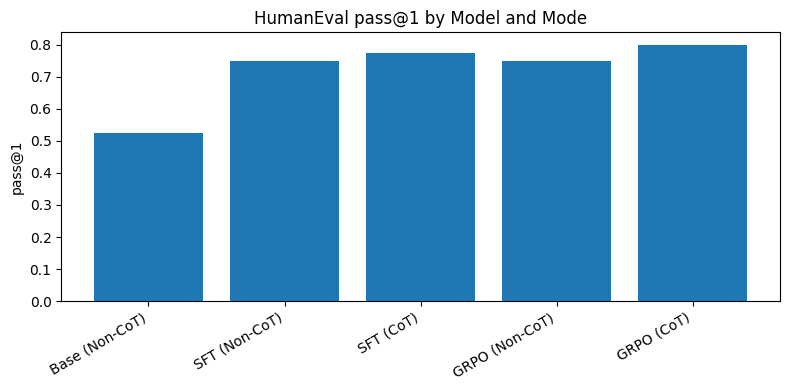

In [62]:
df_results = df_results.copy()
df_results["Label_ml"] = df_results["Model"] + " (" + df_results["Mode"] + ")"

plt.figure(figsize=(8, 4))
plt.bar(df_results["Label_ml"], df_results["pass@1"])
plt.ylabel("pass@1")
plt.title("HumanEval pass@1 by Model and Mode")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [63]:
def get_score(model: str, mode: str) -> float:
    s = df_results.loc[
        (df_results["Model"] == model) & (df_results["Mode"] == mode),
        "pass@1"
    ]
    if len(s) != 1:
        raise ValueError(f"Expected exactly 1 row for ({model}, {mode}), got {len(s)}.")
    return float(s.iloc[0])

deltas = {
    "SFT_CoT_minus_SFT_NonCoT":
        get_score("SFT", "CoT") - get_score("SFT", "Non-CoT"),

    "GRPO_CoT_minus_SFT_CoT":
        get_score("GRPO", "CoT") - get_score("SFT", "CoT"),

    "GRPO_CoT_minus_Base_NonCoT":
        get_score("GRPO", "CoT") - get_score("Base", "Non-CoT"),
}

for k, v in deltas.items():
    print(f"{k}: {v:.4f}")

SFT_CoT_minus_SFT_NonCoT: 0.0244
GRPO_CoT_minus_SFT_CoT: 0.0244
GRPO_CoT_minus_Base_NonCoT: 0.2744


# Step 11: Fixing Metadata

In [1]:
import nbformat
import os

In [2]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# List the notebook directory to confirm the file exists
os.listdir("/content/drive/MyDrive/grpo-verified-reasoner/notebooks")

In [ ]:
notebook_path = "/content/drive/MyDrive/grpo-verified-reasoner/notebooks/06_evaluation_2.ipynb"

with open(notebook_path, "r") as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

with open(notebook_path, "w") as f:
    nbformat.write(nb, f)

print("Notebook fixed and saved successfully!")